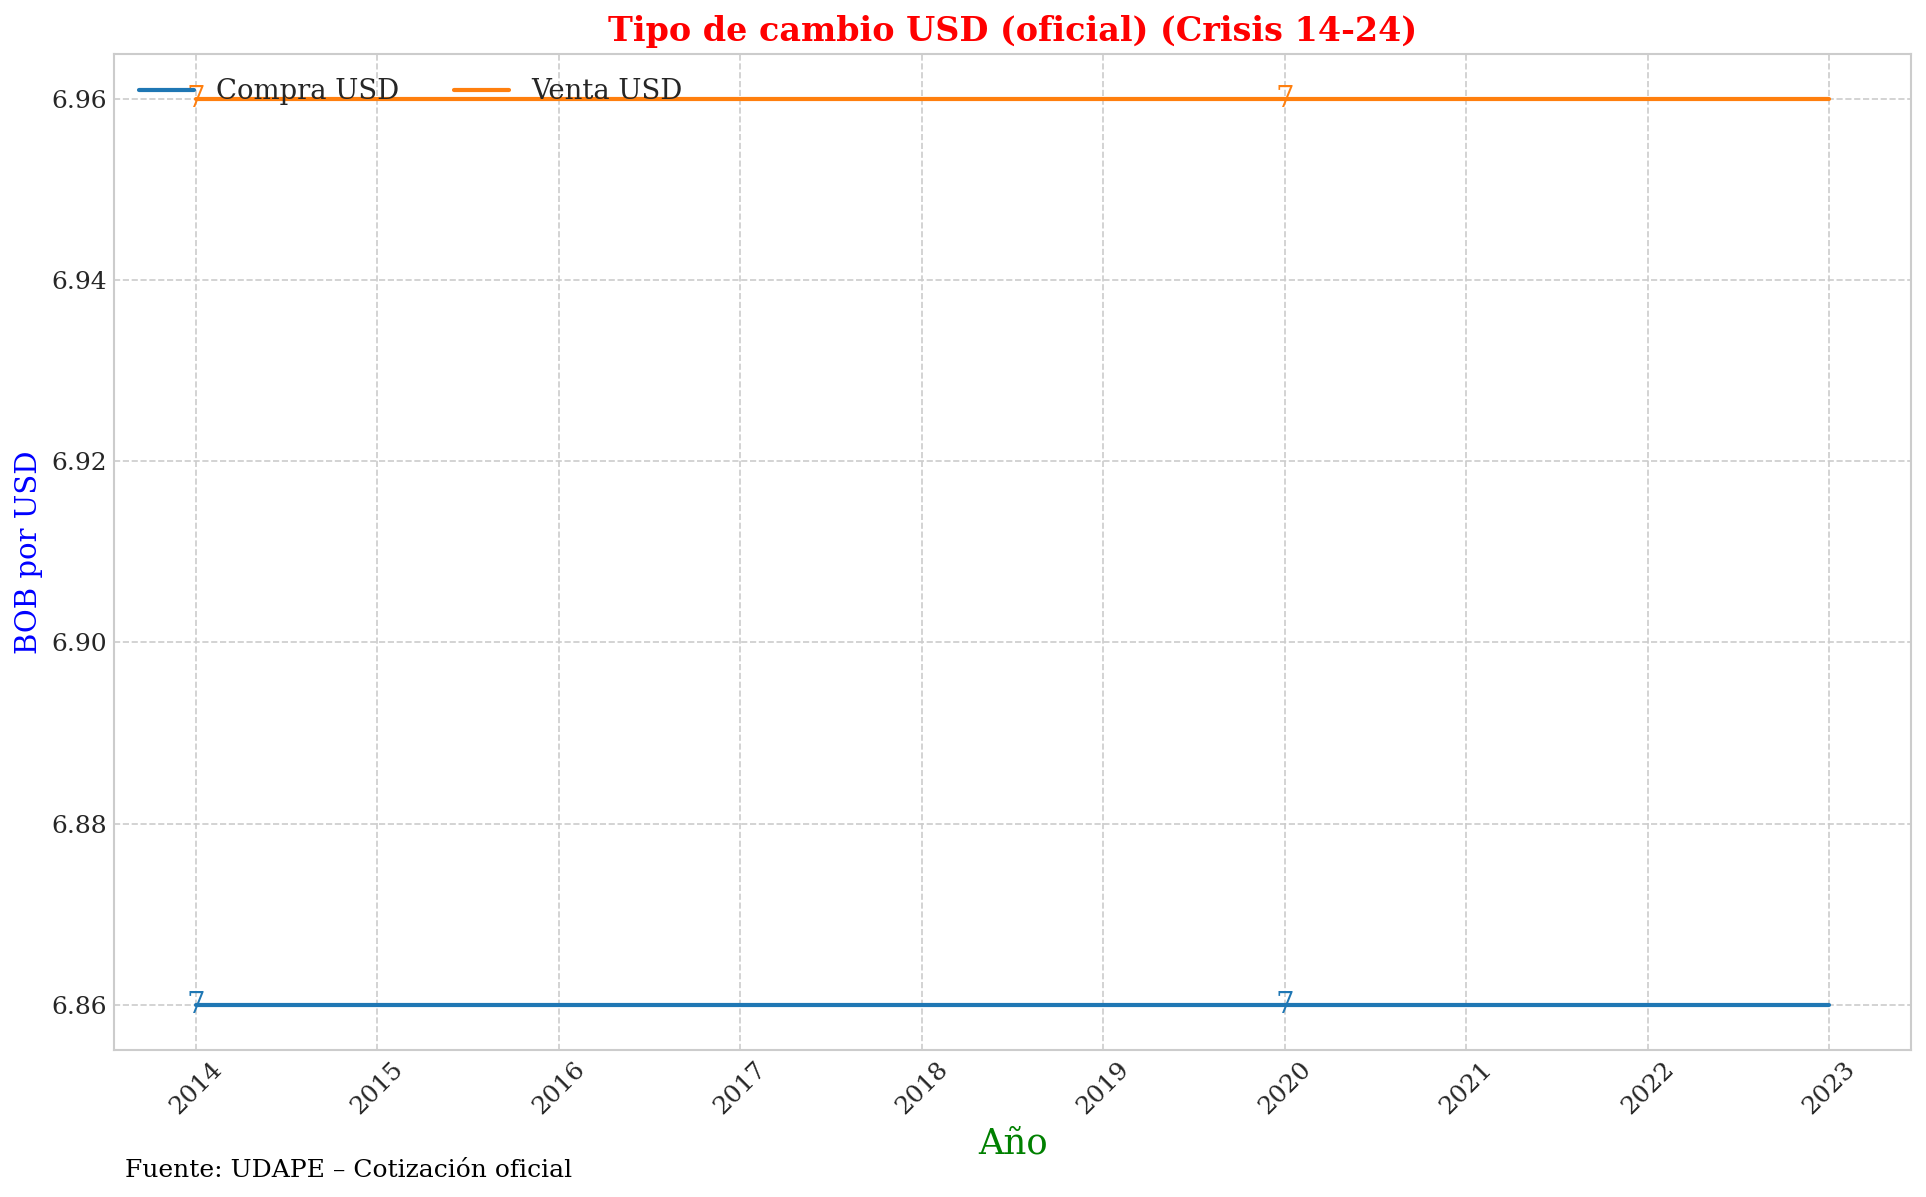

In [3]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones
# ─────────────────────────────────────────────────────────────────────
import sys, os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Si aún no instalaste el paquete en editable, descomenta la siguiente línea:
# sys.path.append(os.path.abspath('../'))

from func_auxiliares.graficos_utils import (
    get_df, set_style, init_base_plot,
    add_year_value_annotations, compute_annot_years
)
from func_auxiliares.config import (
    DB_PATH, ASSETS_DIR,
    PERIODOS_PARA_CRISIS
)

# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = ASSETS_DIR / "crisis" / "tipo_cambio_dolar"
output_dir.mkdir(parents=True, exist_ok=True)

set_style()

# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
SQL = """
    SELECT
      año,
      oficial_compra,
      oficial_venta
    FROM cotizacion_oficial_dolar
"""
df = get_df(SQL, str(DB_PATH), index_col="año")

# ─────────────────────────────────────────────────────────────────────
# Componentes y parámetros de graficado
# ─────────────────────────────────────────────────────────────────────
componentes      = [
    ("oficial_compra", "Compra USD"),
    ("oficial_venta",  "Venta USD")
]
cols_componentes = [col for col, _ in componentes]
colors           = {"oficial_compra": "#1f77b4", "oficial_venta": "#ff7f0e"}

# ─────────────────────────────────────────────────────────────────────
# Offsets y años extra para anotaciones
# ─────────────────────────────────────────────────────────────────────
annotation_offsets = {
    "oficial_compra": {
        1980: (0, 0),
        1986: (0,  0),
        1990: (0, 0),
        2014: (0,  0),
        2020: (0, 0.),
        2024: (0,  0),
    },
    "oficial_venta": {
        1980: (0, 0),
        1986: (0,  0),
        1990: (0, 0),
        2014: (0,  0),
        2020: (0, 0),
        2024: (0,  0),
    }
}

extra_annots = {
    "Crisis 50-60": [],
    "crisis 80-90": [1986],
    "Crisis 14-24": [2020],
}

# ─────────────────────────────────────────────────────────────────────
# Generación de gráficas por sub-período (sin 1950-1960)
# ─────────────────────────────────────────────────────────────────────
for nombre, (ini, fin) in PERIODOS_PARA_CRISIS.items():
    # Omitir el primer período
    if nombre == "Crisis 50-60":
        continue
    sub = df.loc[ini:fin]
    if sub.empty:
        continue

    # Calcula años a anotar: siempre ini/fin + extras dentro del rango
    years_to_annot = compute_annot_years(ini, fin, extra_annots.get(nombre))

    fig, ax = init_base_plot(
        sub,
        series=componentes,
        colors=colors,
        title=f"Tipo de cambio USD (oficial) ({nombre})",
        xlabel="Año",
        ylabel="BOB por USD",
        source_text="Fuente: UDAPE – Cotización oficial"
    )

    add_year_value_annotations(
        ax,
        sub,
        years_to_annot,
        cols_componentes,
        annotation_offsets,
        colors,
        arrow_lw=0.5
    )

    fig.savefig(output_dir / f"tipo_cambio_{nombre}.png")
    plt.show()  # Muestra la gráfica en pantalla
    plt.close(fig)
